<a href="https://colab.research.google.com/github/blinov-89/netolog/blob/main/%D0%98%D1%82%D0%BE%D0%B3%22Score_%3D_0_867095_%D0%9D%D0%B5%D1%82%D0%BE%D0%BB%D0%BE%D0%B3%D0%B8%D1%8F_baseline_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Модель прогнозирования выбора образовательных курсов пользователями

## Загрузим нужные библиотеки

In [1]:
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import numpy as np
from sklearn.metrics import recall_score, precision_score

%matplotlib inline

In [3]:
 from scipy import stats
 from scipy.stats import randint
 from sklearn.model_selection import RandomizedSearchCV
 from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score,roc_auc_score

In [4]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Рассмотрим датасет по ближе

In [7]:
df = pd.read_csv("/content/drive/MyDrive/Оренбург ИИ/train_dataset_train (2).csv")

In [8]:
# pip install pandas_profiling

In [9]:
# import pandas as pd
# import pandas_profiling

In [10]:
# pd.read_csv('/content/drive/MyDrive/Оренбург ИИ/train_dataset_train (2).csv').profile_report()

In [11]:
df.head(3)

,id,age_indicator,month_id,student_id,program_id,carts_created_at,spent_time_total,spent_time_to_complete_hw,completed_hw,failed_hw,...,p_total_calls,p_was_conversations,p_total_duration,support_feedback_avg,feedback_avg_d1,feedback_avg_d2,feedback_avg_d3,feedback_avg_d4,feedback_avg_d5,target
0,15182,32.0,9/30/2020,6694527,1469,8/26/2020,163.0,0.0,1.0,0.0,...,NaN,NaN,NaN,4.0,5.0,NaN,NaN,NaN,NaN,0
1,89385,NaN,6/30/2021,6712877,1392,8/5/2020,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,47931,NaN,2/28/2021,6659444,376,6/20/2020,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [12]:
df.shape

(200000, 59)

In [13]:
df.isnull().sum()

id                                0
age_indicator                 40877
month_id                          0
student_id                        0
program_id                        0
carts_created_at                  0
spent_time_total             113691
spent_time_to_complete_hw    157533
completed_hw                 102401
failed_hw                    102401
reworked_hw                  102401
interacted_hw                102401
avg_hw_mark                  155504
test_with_good_mark          102401
test_with_great_mark         102401
webinars                     102401
avg_quiz_result              183741
notes                        102401
hw_leader                    102401
lessons                      102401
activity                     102401
bought_d1                         0
bought_d2                         0
bought_d3                         0
bought_d4                         0
bought_d5                         0
bought_avg_duration          189641
payment_type                

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 59 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         200000 non-null  int64  
 1   age_indicator              159123 non-null  float64
 2   month_id                   200000 non-null  object 
 3   student_id                 200000 non-null  int64  
 4   program_id                 200000 non-null  int64  
 5   carts_created_at           200000 non-null  object 
 6   spent_time_total           86309 non-null   float64
 7   spent_time_to_complete_hw  42467 non-null   float64
 8   completed_hw               97599 non-null   float64
 9   failed_hw                  97599 non-null   float64
 10  reworked_hw                97599 non-null   float64
 11  interacted_hw              97599 non-null   float64
 12  avg_hw_mark                44496 non-null   float64
 13  test_with_good_mark        97

In [15]:
df['age_indicator'] = df['age_indicator'].fillna((df['age_indicator'].median()))

In [16]:
df['gender'].value_counts()

0.0    87636
1.0    69315
2.0    42989
Name: gender, dtype: int64

In [17]:
df["gender"].fillna(0, inplace = True)

In [18]:
df.describe()

,id,age_indicator,student_id,program_id,spent_time_total,spent_time_to_complete_hw,completed_hw,failed_hw,reworked_hw,interacted_hw,...,p_total_calls,p_was_conversations,p_total_duration,support_feedback_avg,feedback_avg_d1,feedback_avg_d2,feedback_avg_d3,feedback_avg_d4,feedback_avg_d5,target
count,200000.000000,200000.000000,2.000000e+05,200000.000000,86309.000000,42467.000000,97599.000000,97599.000000,97599.000000,97599.000000,...,16453.000000,16453.000000,16453.000000,37557.000000,48496.000000,14805.000000,17778.000000,25076.000000,15733.000000,200000.000000
mean,142407.631250,20.320590,6.671167e+06,962.271990,77.865344,-0.000024,1.335106,0.023330,5.859230,3.439267,...,2.081383,1.266213,49.400290,4.837408,4.507259,4.320306,4.464710,4.490328,4.430035,0.296325
std,82262.564288,10.260861,8.868178e+05,546.947217,115.236108,0.004853,1.979112,0.657045,16.102704,2.053506,...,3.126983,1.208457,48.028241,0.506014,0.649541,0.791206,0.711231,0.665097,0.762329,0.951263
min,1.000000,1.000000,4.920000e+02,12.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,2.000000,...,1.000000,0.000000,0.000000,0.943000,0.943000,0.943000,0.943000,0.943000,0.943000,0.000000
25%,71190.750000,13.000000,6.652468e+06,490.000000,9.000000,0.000000,0.000000,0.000000,0.000000,2.000000,...,1.000000,1.000000,9.000000,4.715000,4.142857,4.000000,4.086333,4.149200,4.000000,0.000000
50%,142332.500000,20.000000,6.814122e+06,916.000000,38.000000,0.000000,0.000000,0.000000,0.000000,2.000000,...,1.000000,1.000000,44.000000,5.000000,4.715000,4.567568,4.715000,4.715000,4.715000,0.000000
75%,213600.500000,28.000000,7.049847e+06,1360.000000,97.000000,0.000000,2.000000,0.000000,0.000000,4.000000,...,2.000000,2.000000,70.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,0.000000
max,284995.000000,40.000000,8.010481e+06,2714.000000,1979.000000,0.000000,34.000000,41.000000,721.000000,38.000000,...,63.000000,28.000000,395.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [19]:
df.age_indicator.mean()

20.32059

In [20]:
df['carts_created_at']= (pd.to_datetime(df['carts_created_at']))

In [21]:
df['month_id']= (pd.to_datetime(df['month_id']))

In [22]:
# df[df['month_id'] > '2020-12-31'].info()

In [23]:
df['days']= (pd.to_datetime(df['month_id']) - pd.to_datetime(df['carts_created_at']))
df['MM_id'] = pd.DatetimeIndex(df['month_id']).month
df['year'] = pd.DatetimeIndex(df['month_id']).year

In [24]:
df['MM_carts_created'] = pd.DatetimeIndex(df['carts_created_at']).month
df['year_carts_created_at'] = pd.DatetimeIndex(df['carts_created_at']).year

In [25]:
df['w_id'] = pd.DatetimeIndex(df['month_id']).weekday
df['w_carts'] = pd.DatetimeIndex(df['carts_created_at']).weekday

In [26]:
df.days.value_counts()  

11 days     1076
32 days     1052
12 days      986
31 days      975
42 days      963
            ... 
542 days       2
539 days       1
547 days       1
538 days       1
540 days       1
Name: days, Length: 544, dtype: int64

In [27]:
df['days'] = df['days'].dt.days.astype('int16')

In [28]:
df.communication_type.value_counts()                   

order    120786
web       49759
phone     28050
Name: communication_type, dtype: int64

In [29]:
df["communication_type"].unique()

array(['phone', 'order', 'web', nan], dtype=object)

In [30]:
df["communication_type"].fillna(3, inplace = True)

In [31]:
cleanup_nums = {"communication_type": {"nan": 0, "phone": 1, "web": 2, "order": 3}}

In [32]:
df = df.replace(cleanup_nums)

In [33]:
# df["communication_type"].fillna('order', inplace = True)

In [34]:
df["ABC"].unique()

array(['D', 'A', 'B', 'C'], dtype=object)

In [35]:
cleanup_nums = {"ABC": {"D": 0, "A": 1, "B": 2, "C": 3}}

In [36]:
df = df.replace(cleanup_nums)

In [37]:
df["promo"].unique()

array(['+', '-'], dtype=object)

In [38]:
df["promo"].value_counts()

-    138595
+     61405
Name: promo, dtype: int64

In [39]:
cleanup_nums = {"promo": {"+": 1, "-": 0}}

In [40]:
df = df.replace(cleanup_nums)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 66 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   id                         200000 non-null  int64         
 1   age_indicator              200000 non-null  float64       
 2   month_id                   200000 non-null  datetime64[ns]
 3   student_id                 200000 non-null  int64         
 4   program_id                 200000 non-null  int64         
 5   carts_created_at           200000 non-null  datetime64[ns]
 6   spent_time_total           86309 non-null   float64       
 7   spent_time_to_complete_hw  42467 non-null   float64       
 8   completed_hw               97599 non-null   float64       
 9   failed_hw                  97599 non-null   float64       
 10  reworked_hw                97599 non-null   float64       
 11  interacted_hw              97599 non-null   float64 

#Пострим на распределение данных

Text(0.5, 1.0, 'Распределение предсказываемой величены')

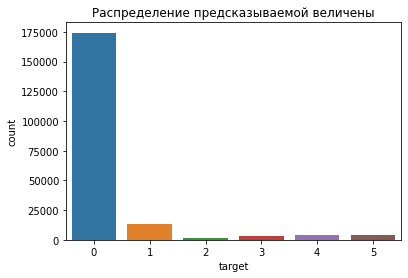

In [ ]:
sns.countplot(x = "target" , data  = df).set_title('Распределение предсказываемой величены')

Text(0.5, 1.0, 'Распределение возраста')

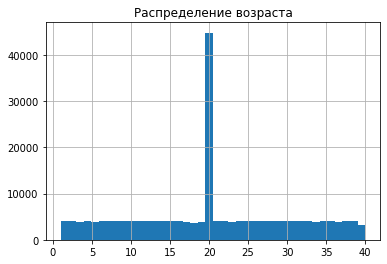

In [ ]:
df["age_indicator"].hist(bins = 40).set_title('Распределение возраста')

In [ ]:
max(df["age_indicator"])

40.0

Взглянем на несколько величин сразу

In [ ]:
df.columns

Index(['id', 'age_indicator', 'month_id', 'student_id', 'program_id',
       'carts_created_at', 'spent_time_total', 'spent_time_to_complete_hw',
       'completed_hw', 'failed_hw', 'reworked_hw', 'interacted_hw',
       'avg_hw_mark', 'test_with_good_mark', 'test_with_great_mark',
       'webinars', 'avg_quiz_result', 'notes', 'hw_leader', 'lessons',
       'activity', 'bought_d1', 'bought_d2', 'bought_d3', 'bought_d4',
       'bought_d5', 'bought_avg_duration', 'payment_type', 'promo', 'price',
       'communication_type', 'auto_payment', 'ABC', 'city', 'country',
       'gender', 'speed_recall', 'os', 'browser', 'platform',
       'm_avg_talk_duration', 'm_avg_duration', 'm_missed_calls',
       'm_total_calls', 'm_was_conversations', 'm_total_duration',
       'p_avg_talk_duration', 'p_avg_duration', 'p_missed_calls',
       'p_total_calls', 'p_was_conversations', 'p_total_duration',
       'support_feedback_avg', 'feedback_avg_d1', 'feedback_avg_d2',
       'feedback_avg_d3', 'fee

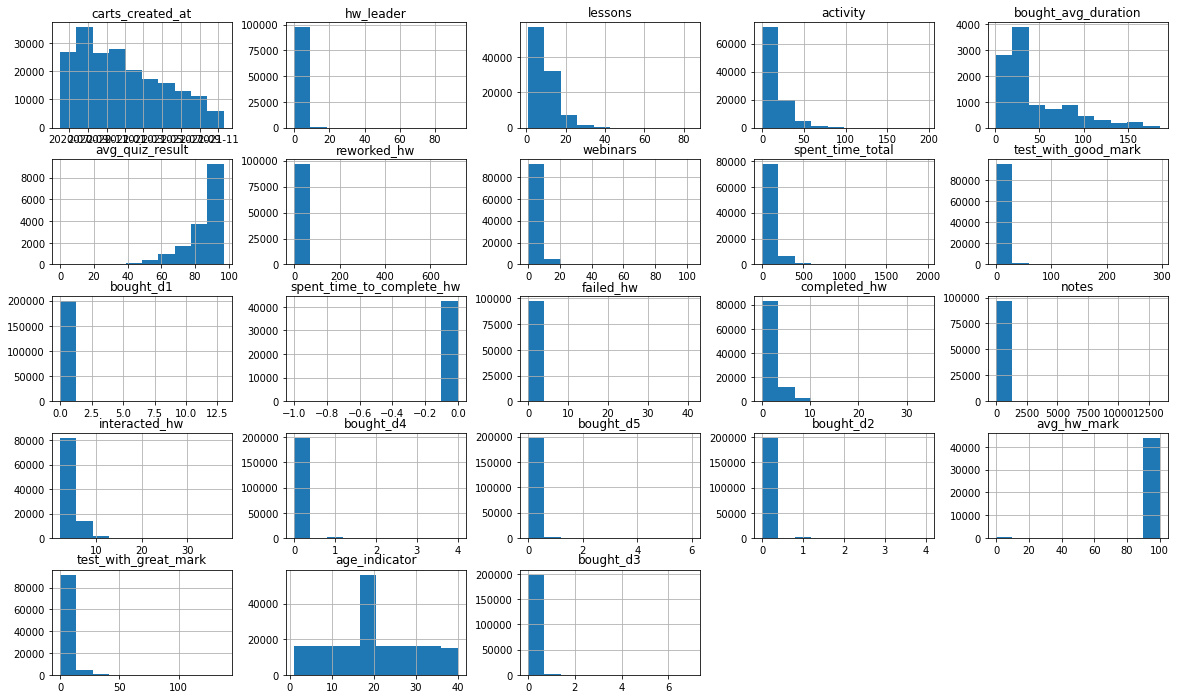

In [ ]:
features = list(set(['age_indicator',
       'carts_created_at', 'spent_time_total', 'spent_time_to_complete_hw',
       'completed_hw', 'failed_hw', 'reworked_hw', 'interacted_hw',
       'avg_hw_mark', 'test_with_good_mark', 'test_with_great_mark',
       'webinars', 'avg_quiz_result', 'notes', 'hw_leader', 'lessons',
       'activity', 'bought_d1', 'bought_d2', 'bought_d3', 'bought_d4',
       'bought_d5', 'bought_avg_duration']))

_ = df[features].hist(figsize=(20,12))

Обратим внимание на часть столбцов с постоянными значениями

In [ ]:
df.spent_time_to_complete_hw.value_counts()

 0.0    42466
-1.0        1
Name: spent_time_to_complete_hw, dtype: int64

In [ ]:
df.bought_d4.value_counts()

0    198694
1      1262
3        40
4         4
Name: bought_d4, dtype: int64

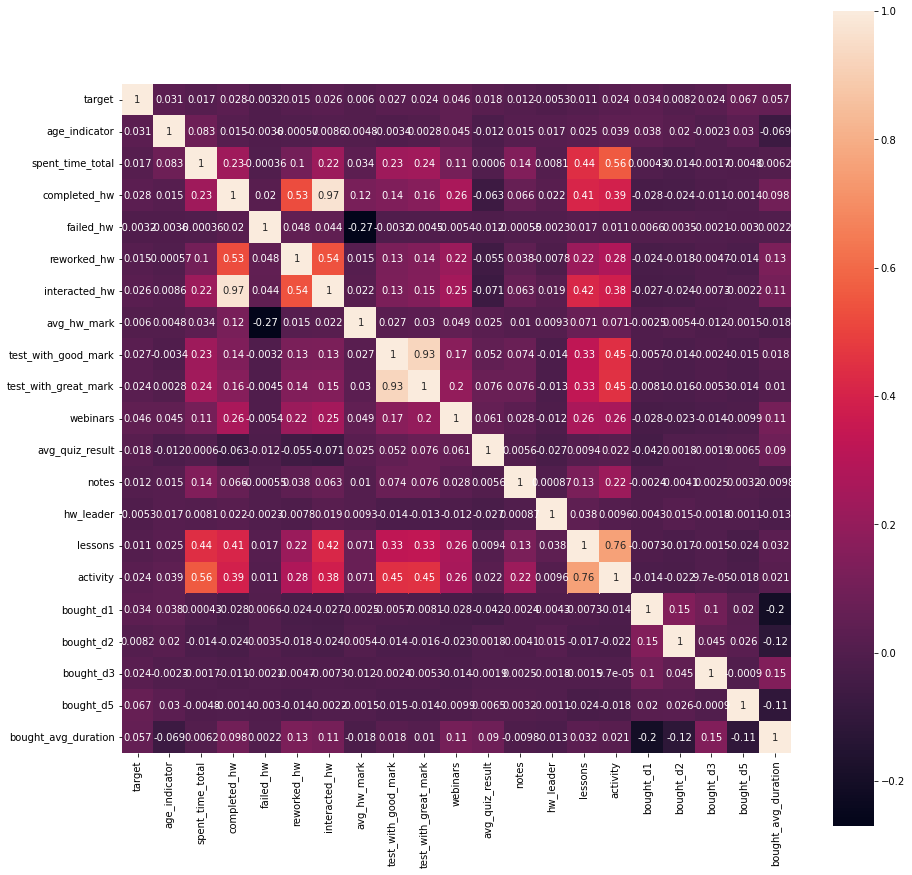

In [ ]:
plt.rcParams['figure.figsize']=(15,15)

df_corr = df[["target",'age_indicator',
       'carts_created_at', 'spent_time_total',
       'completed_hw', 'failed_hw', 'reworked_hw', 'interacted_hw',
       'avg_hw_mark', 'test_with_good_mark', 'test_with_great_mark',
       'webinars', 'avg_quiz_result', 'notes', 'hw_leader', 'lessons',
       'activity', 'bought_d1', 'bought_d2', 'bought_d3',
       'bought_d5', 'bought_avg_duration']]

g = sns.heatmap(df_corr.corr(), square = True, annot=True)

In [ ]:
# df.to_csv('df.csv',  index=True)

In [ ]:
df['target'].value_counts()

0    174301
1     13512
5      3678
4      3659
3      3027
2      1823
Name: target, dtype: int64

# Выделим выборки

In [42]:
df.dtypes[df.dtypes == "object"].values

array([dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O')],
      dtype=object)

Поместим все столбцы object в массив, для их дальнейшего удаления

In [43]:
mass_object = df.dtypes[df.dtypes == "object"].index.values

In [44]:
mass_object = np.append(mass_object, "target")

In [45]:
mass_object

array(['city', 'country', 'os', 'browser', 'platform', 'target'],
      dtype=object)

In [46]:
X = df.drop(mass_object, axis = 1)
y = df[["target"]]

In [47]:
mass_null = X.dtypes[X.isnull().sum() != 0].index.values

In [48]:
mass_null

array(['spent_time_total', 'spent_time_to_complete_hw', 'completed_hw',
       'failed_hw', 'reworked_hw', 'interacted_hw', 'avg_hw_mark',
       'test_with_good_mark', 'test_with_great_mark', 'webinars',
       'avg_quiz_result', 'notes', 'hw_leader', 'lessons', 'activity',
       'bought_avg_duration', 'speed_recall', 'm_avg_talk_duration',
       'm_avg_duration', 'm_missed_calls', 'm_total_calls',
       'm_was_conversations', 'm_total_duration', 'p_avg_talk_duration',
       'p_avg_duration', 'p_missed_calls', 'p_total_calls',
       'p_was_conversations', 'p_total_duration', 'support_feedback_avg',
       'feedback_avg_d1', 'feedback_avg_d2', 'feedback_avg_d3',
       'feedback_avg_d4', 'feedback_avg_d5'], dtype=object)

In [49]:
X = X.drop(mass_null, axis = 1)

In [50]:
X = X.drop(['month_id', 'carts_created_at'], axis = 1)

In [51]:
X.shape

(200000, 23)

In [52]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     200000 non-null  int64  
 1   age_indicator          200000 non-null  float64
 2   student_id             200000 non-null  int64  
 3   program_id             200000 non-null  int64  
 4   bought_d1              200000 non-null  int64  
 5   bought_d2              200000 non-null  int64  
 6   bought_d3              200000 non-null  int64  
 7   bought_d4              200000 non-null  int64  
 8   bought_d5              200000 non-null  int64  
 9   payment_type           200000 non-null  int64  
 10  promo                  200000 non-null  int64  
 11  price                  200000 non-null  float64
 12  communication_type     200000 non-null  int64  
 13  auto_payment           200000 non-null  int64  
 14  ABC                    200000 non-nu

In [53]:
X

,id,age_indicator,student_id,program_id,bought_d1,bought_d2,bought_d3,bought_d4,bought_d5,payment_type,...,auto_payment,ABC,gender,days,MM_id,year,MM_carts_created,year_carts_created_at,w_id,w_carts
0,15182,32.0,6694527,1469,0,0,0,0,0,1,...,0,0,1.0,35,9,2020,8,2020,2,2
1,89385,20.0,6712877,1392,0,0,0,0,0,1,...,1,1,0.0,329,6,2021,8,2020,2,2
2,47931,20.0,6659444,376,0,0,0,0,0,1,...,0,0,0.0,253,2,2021,6,2020,6,5
3,279085,1.0,7151591,1160,0,0,0,0,0,1,...,1,2,1.0,230,11,2021,4,2021,1,2
4,7806,30.0,6705666,952,0,0,0,0,0,1,...,1,1,1.0,104,10,2020,7,2020,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,179932,27.0,6816668,1043,1,0,0,1,0,1,...,1,0,1.0,410,11,2021,10,2020,1,4
199996,257734,20.0,6984939,1635,0,0,0,0,0,1,...,0,0,0.0,271,9,2021,1,2021,3,5
199997,43549,17.0,6670084,789,0,0,0,0,0,1,...,0,0,1.0,275,3,2021,6,2020,2,0
199998,100800,20.0,6917324,476,0,0,0,0,0,1,...,1,1,0.0,205,6,2021,12,2020,2,0


# smote

In [55]:
from imblearn.over_sampling import SMOTE
# X_resampled, y_resampled = SMOTE().fit_resample(X, y)

In [ ]:
sm = SMOTE(random_state=42, k_neighbors=5)

In [ ]:
X_resampled, y_resampled = sm.fit_resample(X, y)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

# далее

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Обучение модели

In [ ]:
# clf = RandomForestClassifier(random_state=0)

In [ ]:
# clf.fit(X_train, y_train)

In [ ]:
# forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
# forest_params = {'max_depth': range(18,25), 'min_samples_leaf': [1, 3, 5, 7],
# 'max_features': range(10,23)}
# forest_grid = GridSearchCV(forest, forest_params,
# cv=2, n_jobs=-1,
# verbose=True)
# forest_grid.fit(X_train, y_train)
# forest_grid.best_params_, forest_grid.best_score_ 

In [ ]:
# accuracy_score(y_test, forest_grid.predict(X_test))

# модель 2

In [ ]:
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# parameters = {'max_features': [4, 7, 10, 13], 'min_samples_leaf': [1, 3, 5, 7], 'max_depth': [5,10,15,20]}
# rfc = RandomForestClassifier(n_estimators=100, random_state=42, 
#                              n_jobs=-1, oob_score=True)
# gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
# gcv.fit(X_train, y_train)

In [ ]:
gcv.best_params_, gcv.best_score_ 

({'max_depth': 40, 'max_features': 23, 'min_samples_leaf': 1},
 0.9580466666666666)

In [58]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
parameters = {'max_features': [23], 'min_samples_leaf': [1], 'max_depth': [40]}
rfc = RandomForestClassifier(n_estimators=100, random_state=42, 
                             n_jobs=-1, oob_score=True)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [40], 'max_features': [23],
                         'min_samples_leaf': [1]},
             verbose=1)

последнее решение

In [ ]:
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# parameters = {'max_features': range(10,23), 'min_samples_leaf': [1, 3], 'max_depth': range(18,25)}
# rfc = RandomForestClassifier(n_estimators=100, random_state=42, 
#                              n_jobs=-1, oob_score=True)
# gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
# gcv.fit(X_train, y_train)

In [59]:
gcv.best_params_, gcv.best_score_ 

({'max_depth': 40, 'max_features': 23, 'min_samples_leaf': 1},
 0.9811692170906238)

In [ ]:
# gcv.best_params_, gcv.best_score_ 

({'max_depth': 40, 'max_features': 23, 'min_samples_leaf': 1},
 0.9580466666666666)

## Оценка точности

In [ ]:
# pred = forest_grid.predict(X_test)

In [60]:
pred = gcv.predict(X_test)

In [ ]:
# pred = clf.predict(X_test)

MODEL

In [ ]:
# 0.2* recall_score(y_test, pred, average='macro') + 0.8* precision_score(y_test, pred, average='macro')

0.9127162788614701

gcv

In [61]:
0.2* recall_score(y_test, pred, average='macro') + 0.8* precision_score(y_test, pred, average='macro')

0.9855035181083625

# test

In [62]:
test = pd.read_csv("/content/drive/MyDrive/Оренбург ИИ/test_dataset_test (3).csv")

In [63]:
test.head(3)

,id,age_indicator,month_id,student_id,program_id,carts_created_at,spent_time_total,spent_time_to_complete_hw,completed_hw,failed_hw,...,p_missed_calls,p_total_calls,p_was_conversations,p_total_duration,support_feedback_avg,feedback_avg_d1,feedback_avg_d2,feedback_avg_d3,feedback_avg_d4,feedback_avg_d5
0,77551,NaN,5/31/2021,7064806,1395,2/28/2021,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,227812,27.0,5/31/2021,6982061,245,1/1/2021,81.0,0.0,5.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,103035,9.0,6/30/2021,7118790,1233,3/19/2021,49.0,0.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN


In [64]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84997 entries, 0 to 84996
Data columns (total 58 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         84997 non-null  int64  
 1   age_indicator              67548 non-null  float64
 2   month_id                   84997 non-null  object 
 3   student_id                 84997 non-null  int64  
 4   program_id                 84997 non-null  int64  
 5   carts_created_at           84997 non-null  object 
 6   spent_time_total           36687 non-null  float64
 7   spent_time_to_complete_hw  18046 non-null  float64
 8   completed_hw               41481 non-null  float64
 9   failed_hw                  41481 non-null  float64
 10  reworked_hw                41481 non-null  float64
 11  interacted_hw              41481 non-null  float64
 12  avg_hw_mark                18909 non-null  float64
 13  test_with_good_mark        41481 non-null  flo

In [65]:
test['age_indicator'] = test['age_indicator'].fillna((test['age_indicator'].median()))

In [66]:
test['gender'].value_counts()

0.0    37246
1.0    29219
2.0    18513
Name: gender, dtype: int64

In [67]:
test["gender"].fillna(0, inplace = True)

In [68]:
test.age_indicator.mean()

20.34397684624163

In [69]:
test['carts_created_at']= (pd.to_datetime(test['carts_created_at']))

In [70]:
test['month_id']= (pd.to_datetime(test['month_id']))

In [71]:
test['days']= (pd.to_datetime(test['month_id']) - pd.to_datetime(test['carts_created_at']))
test['MM_id'] = pd.DatetimeIndex(test['month_id']).month
test['year'] = pd.DatetimeIndex(test['month_id']).year

In [72]:
test['MM_carts_created'] = pd.DatetimeIndex(test['carts_created_at']).month
test['year_carts_created_at'] = pd.DatetimeIndex(test['carts_created_at']).year

In [73]:
test['w_id'] = pd.DatetimeIndex(test['month_id']).weekday
test['w_carts'] = pd.DatetimeIndex(test['carts_created_at']).weekday

In [74]:
test.days.value_counts()  

11 days     476
12 days     437
32 days     424
31 days     414
42 days     386
           ... 
547 days      2
543 days      1
540 days      1
544 days      1
535 days      1
Name: days, Length: 542, dtype: int64

In [75]:
test['days'] = test['days'].dt.days.astype('int16')

In [76]:
test["communication_type"].unique()

array(['order', 'web', 'phone', nan], dtype=object)

In [77]:
test["communication_type"].fillna(3, inplace = True)

In [78]:
cleanup_nums = {"communication_type": {"nan": 0, "phone": 1, "web": 2, "order": 3}}

In [79]:
test = test.replace(cleanup_nums)

In [80]:
# df["communication_type"].fillna('order', inplace = True)

In [81]:
test["ABC"].unique()

array(['B', 'D', 'C', 'A'], dtype=object)

In [82]:
cleanup_nums = {"ABC": {"D": 0, "A": 1, "B": 2, "C": 3}}

In [83]:
test = test.replace(cleanup_nums)

In [84]:
test["promo"].unique()

array(['-', '+'], dtype=object)

In [85]:
test["promo"].value_counts()

-    59012
+    25985
Name: promo, dtype: int64

In [86]:
cleanup_nums = {"promo": {"+": 1, "-": 0}}

In [87]:
test = test.replace(cleanup_nums)

In [88]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84997 entries, 0 to 84996
Data columns (total 65 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         84997 non-null  int64         
 1   age_indicator              84997 non-null  float64       
 2   month_id                   84997 non-null  datetime64[ns]
 3   student_id                 84997 non-null  int64         
 4   program_id                 84997 non-null  int64         
 5   carts_created_at           84997 non-null  datetime64[ns]
 6   spent_time_total           36687 non-null  float64       
 7   spent_time_to_complete_hw  18046 non-null  float64       
 8   completed_hw               41481 non-null  float64       
 9   failed_hw                  41481 non-null  float64       
 10  reworked_hw                41481 non-null  float64       
 11  interacted_hw              41481 non-null  float64       
 12  avg_

Заменим все пропуски в данных

In [89]:
# test = test.fillna(0)

In [90]:
mass_object = test.dtypes[test.dtypes == "object"].index.values

In [91]:
test = test.drop(mass_object, axis = 1)

In [92]:
mass_null = test.dtypes[test.isnull().sum() != 0].index.values

In [93]:
mass_null

array(['spent_time_total', 'spent_time_to_complete_hw', 'completed_hw',
       'failed_hw', 'reworked_hw', 'interacted_hw', 'avg_hw_mark',
       'test_with_good_mark', 'test_with_great_mark', 'webinars',
       'avg_quiz_result', 'notes', 'hw_leader', 'lessons', 'activity',
       'bought_avg_duration', 'speed_recall', 'm_avg_talk_duration',
       'm_avg_duration', 'm_missed_calls', 'm_total_calls',
       'm_was_conversations', 'm_total_duration', 'p_avg_talk_duration',
       'p_avg_duration', 'p_missed_calls', 'p_total_calls',
       'p_was_conversations', 'p_total_duration', 'support_feedback_avg',
       'feedback_avg_d1', 'feedback_avg_d2', 'feedback_avg_d3',
       'feedback_avg_d4', 'feedback_avg_d5'], dtype=object)

In [94]:
test = test.drop(mass_null, axis = 1)

In [95]:
test = test.drop(['month_id', 'carts_created_at'], axis = 1)

In [96]:
test.shape

(84997, 23)

In [97]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     200000 non-null  int64  
 1   age_indicator          200000 non-null  float64
 2   student_id             200000 non-null  int64  
 3   program_id             200000 non-null  int64  
 4   bought_d1              200000 non-null  int64  
 5   bought_d2              200000 non-null  int64  
 6   bought_d3              200000 non-null  int64  
 7   bought_d4              200000 non-null  int64  
 8   bought_d5              200000 non-null  int64  
 9   payment_type           200000 non-null  int64  
 10  promo                  200000 non-null  int64  
 11  price                  200000 non-null  float64
 12  communication_type     200000 non-null  int64  
 13  auto_payment           200000 non-null  int64  
 14  ABC                    200000 non-nu

In [98]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84997 entries, 0 to 84996
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     84997 non-null  int64  
 1   age_indicator          84997 non-null  float64
 2   student_id             84997 non-null  int64  
 3   program_id             84997 non-null  int64  
 4   bought_d1              84997 non-null  int64  
 5   bought_d2              84997 non-null  int64  
 6   bought_d3              84997 non-null  int64  
 7   bought_d4              84997 non-null  int64  
 8   bought_d5              84997 non-null  int64  
 9   payment_type           84997 non-null  int64  
 10  promo                  84997 non-null  int64  
 11  price                  84997 non-null  float64
 12  communication_type     84997 non-null  int64  
 13  auto_payment           84997 non-null  int64  
 14  ABC                    84997 non-null  int64  
 15  ge

In [99]:
mass_object = test.dtypes[test.dtypes == "object"].index.values

In [100]:
mass_object

array([], dtype=object)

In [101]:
# mass_object = np.append(mass_object)

In [102]:
test = test.drop(mass_object, axis = 1)


In [103]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84997 entries, 0 to 84996
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     84997 non-null  int64  
 1   age_indicator          84997 non-null  float64
 2   student_id             84997 non-null  int64  
 3   program_id             84997 non-null  int64  
 4   bought_d1              84997 non-null  int64  
 5   bought_d2              84997 non-null  int64  
 6   bought_d3              84997 non-null  int64  
 7   bought_d4              84997 non-null  int64  
 8   bought_d5              84997 non-null  int64  
 9   payment_type           84997 non-null  int64  
 10  promo                  84997 non-null  int64  
 11  price                  84997 non-null  float64
 12  communication_type     84997 non-null  int64  
 13  auto_payment           84997 non-null  int64  
 14  ABC                    84997 non-null  int64  
 15  ge

# pred

In [105]:
pred = gcv.predict(test)

In [106]:
# pred = clf.predict(test)

In [107]:
test = test.set_index('id')

In [108]:
submit = test[[]]

In [109]:
submit['target'] = pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [110]:
submit.to_csv('submit_netodolog.csv',  index=True)

In [111]:
submit['target'].value_counts()

0    73950
1     5844
5     1538
4     1537
3     1374
2      754
Name: target, dtype: int64